In [5]:
# 부하량(사용량) 예측 DNN 모델
# pytorch 사용

import torch
import math
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class NeuralNetwork(nn.Module):
    def __init__(self, list_layer):
        super(NeuralNetwork, self).__init__()
        self.layer_list = list_layer
        self.layer_num = 0
        self.activation_num = 0
        self.convolution_num = 0
        self.pool_num = 0

        self.sequential = self.layer_stack(self.layer_list)
        print(self.sequential)

    def forward(self, x):
        i = self.sequential(x)
        return i

    def layer_stack(self, x):
        print(x)
        seq = nn.Sequential()
        for i in x:
            if i[0] == 'ln':
                self.layer_num += 1
                seq.add_module('layer_' + str(self.layer_num) + '_Linear', nn.Linear(i[1], i[2]))
            elif i[0] == 'relu':
                self.activation_num += 1
                seq.add_module('activation_' + str(self.activation_num) + '_Relu', nn.ReLU())
            elif i[0] == 'sigmoid':
                self.activation_num += 1
                seq.add_module('activation_' + str(self.activation_num) + '_Sigmoid', nn.Sigmoid())

        return seq


In [8]:
# 실행환경에 따라 데이터 불러오는 경로 변경 필요
# '/load_data' 오류 발생시 'load_data'로
try:
  load_data = pd.read_csv('load_data')
except FileNotFoundError:
  load_data = pd.read_csv('/load_data')
try:
  weather_data = pd.read_csv('weather_data')
except FileNotFoundError:
  weather_data = pd.read_csv('/weather_data')
dataset = []
start_date = datetime.strptime(weather_data.columns[1],'%Y/%m/%d')
for i in weather_data.columns:
  if i=='Unnamed: 0':
    continue
  day_week = datetime.strptime(i, "%Y/%m/%d")
  for f in range(0,24):
    dataset.append(i.split('/')+[str((day_week-start_date).days),str(day_week.weekday())]+weather_data[i][f].split('/'))
print(dataset)
index=0
for i in load_data.columns:
  if i=='Unnamed: 0':
    continue
  for f in range(0,24):
    dataset[index]+=[load_data[i][f]]
    index+=1
print(dataset)
# 년 월 일 경과날짜 요일 시간 온도 강수량 풍속 풍향 습도 일조 일사 전운량 지면온도 부하량

[['2022', '07', '01', '0', '4', '0', '25.6', 'nan', '2.2', '180', '99', 'nan', 'nan', '3.0', '25.0'], ['2022', '07', '01', '0', '4', '1', '25.1', 'nan', '1.4', '200', '99', 'nan', 'nan', '2.0', '24.8'], ['2022', '07', '01', '0', '4', '2', '25.0', 'nan', '1.8', '180', '99', 'nan', 'nan', '4.0', '24.4'], ['2022', '07', '01', '0', '4', '3', '24.9', 'nan', '1.6', '200', '99', 'nan', 'nan', '2.0', '24.2'], ['2022', '07', '01', '0', '4', '4', '24.5', 'nan', '0.4', '0', '99', 'nan', 'nan', '3.0', '24.0'], ['2022', '07', '01', '0', '4', '5', '24.4', 'nan', '1.0', '50', '99', 'nan', 'nan', '3.0', '24.0'], ['2022', '07', '01', '0', '4', '6', '24.0', 'nan', '0.9', '90', '99', '0.1', '0.1', '2.0', '24.0'], ['2022', '07', '01', '0', '4', '7', '25.1', 'nan', '0.9', '70', '99', '1.0', '0.59', '2.0', '24.5'], ['2022', '07', '01', '0', '4', '8', '27.3', 'nan', '2.5', '200', '88', '1.0', '1.29', '2.0', '27.4'], ['2022', '07', '01', '0', '4', '9', '28.4', 'nan', '3.3', '180', '83', '1.0', '1.96', '1.0', 

In [9]:
npdataset = np.array(dataset)
npdataset[npdataset=='nan']='0'
npdataset = npdataset.astype(float)
print(npdataset[0])

[2.0220e+03 7.0000e+00 1.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
 2.5600e+01 0.0000e+00 2.2000e+00 1.8000e+02 9.9000e+01 0.0000e+00
 0.0000e+00 3.0000e+00 2.5000e+01 6.5956e+03]


In [13]:
# 월 일 요일 시간 온도 습도 부하량 데이터 선택
# min-max scaling

select_col = [1,2,4,5,6,10,15]
data_num = len(select_col)-1
print(data_num)
select_data = npdataset[:,select_col]
min_vals = np.min(select_data, axis=0)
max_vals = np.max(select_data, axis=0)
scaled_data = (select_data - min_vals) / (max_vals - min_vals)
print(scaled_data[0])

6
[0.         0.         0.66666667 0.         0.4702381  1.
 0.28590208]


In [15]:
# 75 : 25 비율로 훈련/검증 데이터셋 분류
def split_data(dset,ratio):
  tx=[]
  ty=[]
  vx=[]
  vy=[]
  for i in dset:
    if(random.uniform(0, 1)<ratio):
      tx.append(i[0:data_num])
      ty.append(i[data_num])
    else:
      vx.append(i[0:data_num])
      vy.append(i[data_num])
  return tx,ty,vx,vy

set_ratio = 0.75

train_X,train_Y,val_X,val_Y = split_data(scaled_data,set_ratio)
train_X=torch.Tensor(train_X).float().to(device)
train_Y=torch.Tensor(train_Y).float().to(device)
val_X=torch.Tensor(val_X).float().to(device)
val_Y=torch.Tensor(val_Y).float().to(device)
print(train_X[0])
print(train_Y[0])

tensor([0.0000, 0.0000, 0.6667, 0.0000, 0.4702, 1.0000])
tensor(0.2859)


In [18]:
# batch size 설정
batch_size = 4
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(val_X, val_Y), batch_size=batch_size, shuffle=False)

In [16]:
# DNN 모델 생성. 24 * 24 크기의 hidden layer 4개, activation은 relu

list_layer = [['ln', data_num, data_num*4],['relu'],['ln',data_num*4, data_num*4],['relu'],['ln', data_num*4, data_num*4],['relu'],['ln', data_num*4, data_num*4],['relu'],['ln', data_num*4, data_num*4],['relu'],['ln', data_num*4, 1]]

model = NeuralNetwork(list_layer).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

[['ln', 6, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 1]]
Sequential(
  (layer_1_Linear): Linear(in_features=6, out_features=24, bias=True)
  (activation_1_Relu): ReLU()
  (layer_2_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_2_Relu): ReLU()
  (layer_3_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_3_Relu): ReLU()
  (layer_4_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_4_Relu): ReLU()
  (layer_5_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_5_Relu): ReLU()
  (layer_6_Linear): Linear(in_features=24, out_features=1, bias=True)
)


In [19]:
#모델 학습

num_epochs = 1000

train_loss=[]
val_loss=[]

vcrit = nn.MSELoss()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_X, batch_Y in train_loader:
      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      #rloss = torch.sqrt(loss)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    vrunning_loss = 0.0
    model.eval()
    with torch.no_grad():
        for vbatch_X, vbatch_Y in val_loader:
          voutputs = model(vbatch_X)
          vloss = vcrit(voutputs,vbatch_Y)
          #rvloss = torch.sqrt(vloss)
          vrunning_loss+=vloss.item()

    train_loss.append(running_loss)
    val_loss.append(vrunning_loss)

    if epoch%100==0:
        print('Epoch: %d | Loss: %.4f' % (epoch + 1, running_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch: 1 | Loss: 27.1484
Epoch: 101 | Loss: 6.0062
Epoch: 201 | Loss: 5.2619
Epoch: 301 | Loss: 5.0283
Epoch: 401 | Loss: 4.9207
Epoch: 501 | Loss: 4.8196
Epoch: 601 | Loss: 4.7243
Epoch: 701 | Loss: 4.6307
Epoch: 801 | Loss: 4.5684
Epoch: 901 | Loss: 4.5184


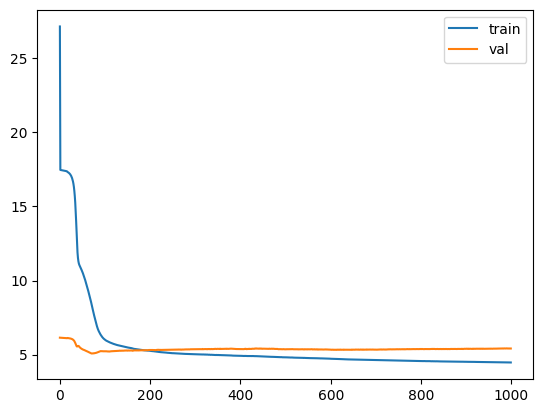

In [20]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.show()

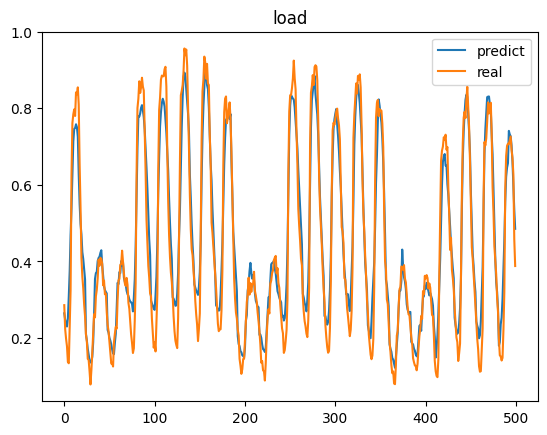

In [22]:
model.eval()
testX = scaled_data[0:500,0:data_num]
testY = scaled_data[0:500,[data_num]]
predictY = model(torch.Tensor(testX))

plt.title('load')
plt.plot(predictY.detach().numpy(),label='predict')
plt.plot(testY,label='real')
plt.legend()
plt.show()

In [36]:
# 경로에 이상있으면 앞의 '/' 를 제거

torch.save(model,'/load_fullmodel1.pt')
torch.save(model.state_dict(),'/load_statedict.pt')

[['ln', 6, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 24], ['relu'], ['ln', 24, 1]]
Sequential(
  (layer_1_Linear): Linear(in_features=6, out_features=24, bias=True)
  (activation_1_Relu): ReLU()
  (layer_2_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_2_Relu): ReLU()
  (layer_3_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_3_Relu): ReLU()
  (layer_4_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_4_Relu): ReLU()
  (layer_5_Linear): Linear(in_features=24, out_features=24, bias=True)
  (activation_5_Relu): ReLU()
  (layer_6_Linear): Linear(in_features=24, out_features=1, bias=True)
)


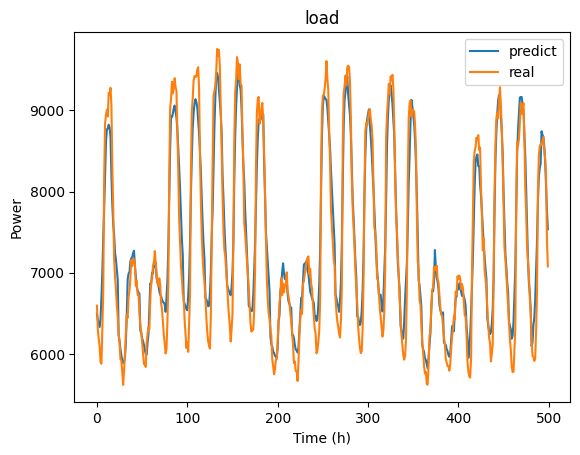

In [33]:
# 모델 저장/불러오기 첫 시간부터 500시간까지의 그래프
test_model = NeuralNetwork(list_layer).to(device)
try:
  test_model.load_state_dict(torch.load('load_statedict.pt'))
except FileNotFoundError:
  test_model.load_state_dict(torch.load('/load_statedict.pt'))
test_model.eval()

ptestX = scaled_data[0:500,0:data_num]
ptestY = scaled_data[0:500,[data_num]]
py = test_model(torch.Tensor(ptestX))
py = py.detach().numpy()
#
mn=min_vals[data_num]
mx=max_vals[data_num]

py = py*(mx-mn)
py = py+mn
ptestY = ptestY*(mx-mn)+mn

plt.title('load')
plt.plot(py,label='predict')
plt.plot(ptestY,label='real')
plt.xlabel('Time (h)')
plt.ylabel('Power')
plt.legend()
plt.show()

[[6486.378 ]
 [6486.631 ]
 [6500.4434]
 [6515.324 ]
 [6421.9536]
 [6439.917 ]
 [6451.8794]
 [6463.7954]
 [6590.4355]
 [6802.059 ]
 [7135.2373]
 [7457.1084]
 [7513.577 ]
 [7725.701 ]
 [7745.8564]
 [7642.253 ]
 [7378.4004]
 [7286.412 ]
 [7146.458 ]
 [7028.1055]
 [7088.84  ]
 [6950.8555]
 [6994.5625]
 [7008.9297]]


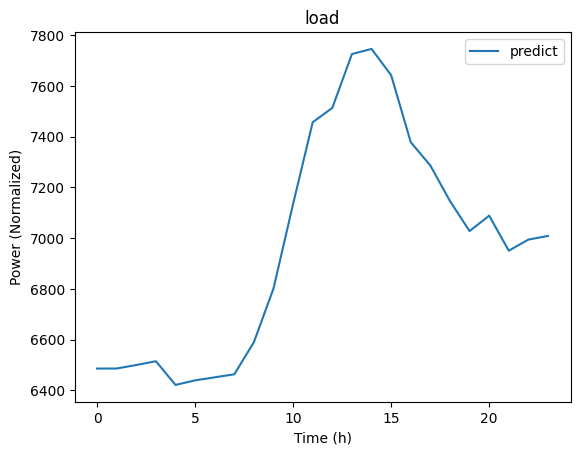

In [37]:
# 2023/8/19(토) 광주광역시 기상예보 기반 부하량 예측
# 월 일 요일 시간 온도 습도

predictX = np.array([[8,19,5,0,26,99],
                     [8,19,5,1,26,99],
                     [8,19,5,2,26,99],
                     [8,19,5,3,26,99],
                     [8,19,5,4,25,99],
                     [8,19,5,5,25,99],
                     [8,19,5,6,25,99],
                     [8,19,5,7,25,99],
                     [8,19,5,8,26,99],
                     [8,19,5,9,28,95],
                     [8,19,5,10,29,90],
                     [8,19,5,11,30,85],
                     [8,19,5,12,30,80],
                     [8,19,5,13,31,80],
                     [8,19,5,14,31,80],
                     [8,19,5,15,31,80],
                     [8,19,5,16,30,80],
                     [8,19,5,17,30,85],
                     [8,19,5,18,29,90],
                     [8,19,5,19,28,90],
                     [8,19,5,20,28,95],
                     [8,19,5,21,27,95],
                     [8,19,5,22,27,99],
                     [8,19,5,23,27,99]]).astype(float)
predictX = (predictX - min_vals[0:6]) / (max_vals[0:6] - min_vals[0:6])
pdy = test_model(torch.Tensor(predictX))

pdy = pdy.detach().numpy()
pdy = pdy*(mx-mn)
pdy = pdy+mn
print(pdy)
plt.title('load')
plt.plot(pdy,label='predict')
plt.xlabel('Time (h)')
plt.ylabel('Power (Normalized)')
plt.legend()
plt.show()
